## Loading Libraries

In [1]:
import numpy as np
import librosa as lbr
import tensorflow.keras.backend as K

In [2]:
GENRES = ['Electronic', 'Experimental', 'Folk', 'HipHop', 'Instrumental', 'International', 'Pop','Rock']
WINDOW_SIZE = 2048
WINDOW_STRIDE = WINDOW_SIZE // 2
N_MELS = 128
MEL_KWARGS = {
    'n_fft': WINDOW_SIZE,
    'hop_length': WINDOW_STRIDE,
    'n_mels': N_MELS
}
import warnings
warnings.filterwarnings('ignore')

## Feature Engineering

In [3]:
def get_layer_output_function(model, layer_name):
    input = model.get_layer('input').input
    output = model.get_layer(layer_name).output
    f = K.function([input, K.learning_phase()], [output])
    return lambda x: f([x, 0])[0] # learning_phase = 0 means test

def load_track(filename, enforce_shape=None):
    new_input, sample_rate = lbr.load(filename, mono=True, duration=40.0)
    features = lbr.feature.melspectrogram(new_input, **MEL_KWARGS).T

    if enforce_shape is not None:
        if features.shape[0] < enforce_shape[0]:
            delta_shape = (enforce_shape[0] - features.shape[0],
                    enforce_shape[1])
            features = np.append(features, np.zeros(delta_shape), axis=0)
        elif features.shape[0] > enforce_shape[0]:
            features = features[: enforce_shape[0], :]

    features[features == 0] = 1e-6
    return (np.log(features), float(new_input.shape[0]) / sample_rate)


## Preparing Prediction Data

In [4]:
def predict_data(dataset_path):
    path = dataset_path
    tmp_features, _ = load_track(dataset_path)
    default_shape = tmp_features.shape
    x = np.zeros((1,) + default_shape, dtype=np.float32)            
    x[0], _ = load_track(path, default_shape)
    return (x)

## Loading Model

In [5]:
from tensorflow.keras.models import Model, load_model
genre_model = Model()
genre_model = load_model('/Users/jairomelo/Desktop/ML/YORK/ML1020/Final Project/model_40s.h5')
#genre_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


## Predicting the Genre

In [6]:
pred_file='/Users/jairomelo/Desktop/ML/YORK/ML1020/Final Project/Test/audio.mp3'
x = predict_data(pred_file)
predictions = genre_model.predict(x)

In [7]:
print(GENRES[np.argmax(predictions[0])])

Experimental


In [12]:
print(predictions[0:8])

[[0.01515855 0.34264296 0.30331504 0.00326534 0.22462995 0.01725536
  0.01842677 0.07530612]]


## A view to the Audio

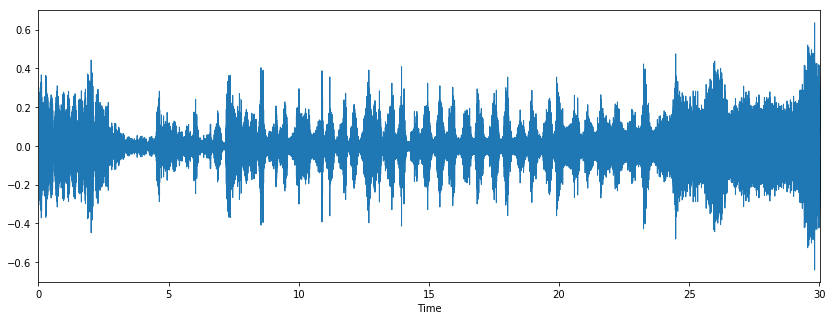

In [11]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

In [9]:
import librosa as lbr
x, sr = lbr.load(pred_file, mono=True, duration=40.0)
melspec= lbr.feature.melspectrogram(x, **MEL_KWARGS).T
